In [3]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [43]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))

print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [44]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [45]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [46]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [50] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [47]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 111


In [48]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]

        theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [49]:
def activation(x):
    return 1/(1+np.exp(-x))

In [50]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [51]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [52]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [53]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

# plt_epoch = []
# plt_train_acc = []
# plt_val_acc = []
# plt_test_acc = []

In [ ]:
lr = 0.1
for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]])
    print(theta[0].shape, theta[1].shape)
    fm = forward_prop(X_train, theta)
    
    epoch = 1
    start = time.time()
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])

    while(True):
        count = 0
        
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))

        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
            fm = forward_prop(X_b, theta)
            delta = [None]*len(fm)

            if (count % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
            #Backward Propagation

            for l in range(len(fm)-1, 0, -1):
                if (l == len(fm)-1):
                    delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                    #print("delta for last layer = ", delta[l])
                else:
                    delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))
                    #print("delta for hidden layer = ", delta[l])


            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count+=1
#             if epoch %10 == 0:
#                 costs.append(cost_init)
#         if (epoch % 200 == 0):
#             plt_epoch.append(epoch)
#             plt_train_acc.append(calc_accuracy(X_train, theta, train_class_enc))
#             plt_val_acc.append(calc_accuracy(X_valid, theta, valid_class_enc))
#             plt_test_acc.append(calc_accuracy(X_test, theta, test_actual_class_enc))
        
        epoch+=1 #Number of epochs
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        if (abs(cost_final-cost_init) < 1e-07):
            print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
            break
        cost_init = cost_final
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {:2.3f}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

(785, 1) (1, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2495192751248383
Error on this batch = 3.2494124139947105
Error on this batch = 1.9752783416646984
Cost on val dataset after 2 epochs is = 1.3858941962374949
Initial Cost on Val dataset for this epoch 2 = 1.3858941962374949
Error on this batch = 1.3868520160119806
Error on this batch = 1.044318185259565
Cost on val dataset after 3 epochs is = 0.8914129883984958
Initial Cost on Val dataset for this epoch 3 = 0.8914129883984958
Error on this batch = 0.891701395324994
Error on this batch = 0.7801870259134575
Cost on val dataset after 4 epochs is = 0.7205744219071063
Initial Cost on Val dataset for this epoch 4 = 0.7205744219071063
Error on this batch = 0.7206940268886817
Error on this batch = 0.6705626827459089
Cost on val dataset after 5 epochs is = 0.6409169045522979
Initial Cost on Val dataset for this epoch 5 = 0.6409169045522979
Error on this batch = 0.6409690146252168
Error on this batch = 0.6137484121616569
Cost on v

Error on this batch = 0.48384484587598636
Cost on val dataset after 41 epochs is = 0.4838100132238476
Initial Cost on Val dataset for this epoch 41 = 0.4838100132238476
Error on this batch = 0.4837351470684905
Error on this batch = 0.4836749949356735
Cost on val dataset after 42 epochs is = 0.48364525527224717
Initial Cost on Val dataset for this epoch 42 = 0.48364525527224717
Error on this batch = 0.4835698137540947
Error on this batch = 0.4835168794610845
Cost on val dataset after 43 epochs is = 0.48349178892734324
Initial Cost on Val dataset for this epoch 43 = 0.48349178892734324
Error on this batch = 0.4834157822454651
Error on this batch = 0.4833694928198296
Cost on val dataset after 44 epochs is = 0.48334865481913614
Initial Cost on Val dataset for this epoch 44 = 0.48334865481913614
Error on this batch = 0.48327209256985276
Error on this batch = 0.48323193319479585
Cost on val dataset after 45 epochs is = 0.4832149924924595
Initial Cost on Val dataset for this epoch 45 = 0.4832

Error on this batch = 0.48127602588948615
Cost on val dataset after 80 epochs is = 0.48130668086046324
Initial Cost on Val dataset for this epoch 80 = 0.48130668086046324
Error on this batch = 0.4812140072614217
Error on this batch = 0.4812567192484298
Cost on val dataset after 81 epochs is = 0.48128778497762675
Initial Cost on Val dataset for this epoch 81 = 0.48128778497762675
Error on this batch = 0.4811947368863821
Error on this batch = 0.4812382705593318
Cost on val dataset after 82 epochs is = 0.4812697294275069
Initial Cost on Val dataset for this epoch 82 = 0.4812697294275069
Error on this batch = 0.481176309812696
Error on this batch = 0.481220636185338
Cost on val dataset after 83 epochs is = 0.4812524716379746
Initial Cost on Val dataset for this epoch 83 = 0.4812524716379746
Error on this batch = 0.4811586834265079
Error on this batch = 0.4812037750640301
Cost on val dataset after 84 epochs is = 0.48123597153626063
Initial Cost on Val dataset for this epoch 84 = 0.481235971

Cost on val dataset after 120 epochs is = 0.4809377289886106
Initial Cost on Val dataset for this epoch 120 = 0.4809377289886106
Error on this batch = 0.4808320933702412
Error on this batch = 0.48089442169925817
Cost on val dataset after 121 epochs is = 0.4809341093738243
Initial Cost on Val dataset for this epoch 121 = 0.4809341093738243
Error on this batch = 0.48082819671461047
Error on this batch = 0.480890818872641
Cost on val dataset after 122 epochs is = 0.48093062604280307
Initial Cost on Val dataset for this epoch 122 = 0.48093062604280307
Error on this batch = 0.4808244384047453
Error on this batch = 0.48088734914611264
Cost on val dataset after 123 epochs is = 0.4809272735810186
Initial Cost on Val dataset for this epoch 123 = 0.4809272735810186
Error on this batch = 0.4808208130131845
Error on this batch = 0.48088400725640773
Cost on val dataset after 124 epochs is = 0.48092404681014916
Initial Cost on Val dataset for this epoch 124 = 0.48092404681014916
Error on this batch 

Cost on val dataset after 159 epochs is = 0.48086245491206103
Initial Cost on Val dataset for this epoch 159 = 0.48086245491206103
Error on this batch = 0.48074743625804434
Error on this batch = 0.480818399294318
Cost on val dataset after 160 epochs is = 0.4808616175527312
Initial Cost on Val dataset for this epoch 160 = 0.4808616175527312
Error on this batch = 0.4807463939032809
Error on this batch = 0.48081752303617814
Cost on val dataset after 161 epochs is = 0.480860811006323
Initial Cost on Val dataset for this epoch 161 = 0.480860811006323
Error on this batch = 0.4807453840051515
Error on this batch = 0.4808166772156842
Cost on val dataset after 162 epochs is = 0.48086003417416934
Initial Cost on Val dataset for this epoch 162 = 0.48086003417416934
Error on this batch = 0.4807444054555414
Error on this batch = 0.48081586076112715
Cost on val dataset after 163 epochs is = 0.4808592859984271
Initial Cost on Val dataset for this epoch 163 = 0.4808592859984271
Error on this batch = 0

Error on this batch = 0.4807995231309499
Cost on val dataset after 199 epochs is = 0.48084501790354245
Initial Cost on Val dataset for this epoch 199 = 0.48084501790354245
Error on this batch = 0.48072299067425506
Error on this batch = 0.48079930358586553
Cost on val dataset after 200 epochs is = 0.4808448467497709
Initial Cost on Val dataset for this epoch 200 = 0.4808448467497709
Error on this batch = 0.48072267316394945
Error on this batch = 0.4807990918494806
Cost on val dataset after 201 epochs is = 0.48084468298089705
Initial Cost on Val dataset for this epoch 201 = 0.48084468298089705
Error on this batch = 0.48072236432386106
Error on this batch = 0.48079888765880563
Cost on val dataset after 202 epochs is = 0.4808445263380103
Initial Cost on Val dataset for this epoch 202 = 0.4808445263380103
Error on this batch = 0.48072206388656824
Error on this batch = 0.4807986907597932
Cost on val dataset after 203 epochs is = 0.4808443765710542
Initial Cost on Val dataset for this epoch 2

Error on this batch = 0.4809281098285607
Cost on val dataset after 25 epochs is = 0.480964464776563
Initial Cost on Val dataset for this epoch 25 = 0.480964464776563
Error on this batch = 0.4808562180401884
Error on this batch = 0.48091268172198354
Cost on val dataset after 26 epochs is = 0.48094847063205937
Initial Cost on Val dataset for this epoch 26 = 0.48094847063205937
Error on this batch = 0.48083768979841446
Error on this batch = 0.48090011374092384
Cost on val dataset after 27 epochs is = 0.480935280841739
Initial Cost on Val dataset for this epoch 27 = 0.480935280841739
Error on this batch = 0.480822130919662
Error on this batch = 0.48088987382302856
Cost on val dataset after 28 epochs is = 0.48092438964895085
Initial Cost on Val dataset for this epoch 28 = 0.48092438964895085
Error on this batch = 0.4808090200431391
Error on this batch = 0.4808815345862631
Cost on val dataset after 29 epochs is = 0.48091538871547623
Initial Cost on Val dataset for this epoch 29 = 0.480915388

Error on this batch = 0.48099560868957286
Cost on val dataset after 15 epochs is = 0.48104370129919877
Initial Cost on Val dataset for this epoch 15 = 0.48104370129919877
Error on this batch = 0.48090177244844795
Error on this batch = 0.48098670046229586
Cost on val dataset after 16 epochs is = 0.4810293399848331
Initial Cost on Val dataset for this epoch 16 = 0.4810293399848331
Error on this batch = 0.4808798017854415
Error on this batch = 0.4809818297750373
Cost on val dataset after 17 epochs is = 0.48101947017549784
Initial Cost on Val dataset for this epoch 17 = 0.48101947017549784
Error on this batch = 0.48086332753976424
Error on this batch = 0.48097956626706156
Cost on val dataset after 18 epochs is = 0.48101268973030276
Initial Cost on Val dataset for this epoch 18 = 0.48101268973030276
Error on this batch = 0.480850780587716
Error on this batch = 0.48097896181226724
Cost on val dataset after 19 epochs is = 0.48100804202422737
Initial Cost on Val dataset for this epoch 19 = 0.4

Error on this batch = 0.4809837328987226
Cost on val dataset after 55 epochs is = 0.48098463831332744
Initial Cost on Val dataset for this epoch 55 = 0.48098463831332744
Error on this batch = 0.48078400702376367
Error on this batch = 0.48098306995351736
Cost on val dataset after 56 epochs is = 0.4809840060341074
Initial Cost on Val dataset for this epoch 56 = 0.4809840060341074
Error on this batch = 0.48078357215719364
Error on this batch = 0.4809824042683886
Cost on val dataset after 57 epochs is = 0.48098337502651983
Initial Cost on Val dataset for this epoch 57 = 0.48098337502651983
Error on this batch = 0.48078314611057665
Error on this batch = 0.48098173683318424
Cost on val dataset after 58 epochs is = 0.4809827457496624
Initial Cost on Val dataset for this epoch 58 = 0.4809827457496624
Error on this batch = 0.4807827282944496
Error on this batch = 0.4809810685167849
Cost on val dataset after 59 epochs is = 0.4809821186073101
Initial Cost on Val dataset for this epoch 59 = 0.4809

Error on this batch = 0.48095962817045346
Cost on val dataset after 94 epochs is = 0.48096260668026103
Initial Cost on Val dataset for this epoch 94 = 0.48096260668026103
Error on this batch = 0.48077084230786976
Error on this batch = 0.48095908975426227
Cost on val dataset after 95 epochs is = 0.4809621235248204
Initial Cost on Val dataset for this epoch 95 = 0.4809621235248204
Error on this batch = 0.48077057018609326
Error on this batch = 0.4809585553384039
Cost on val dataset after 96 epochs is = 0.4809616441786922
Initial Cost on Val dataset for this epoch 96 = 0.4809616441786922
Error on this batch = 0.4807703004407381
Error on this batch = 0.48095802488506023
Cost on val dataset after 97 epochs is = 0.4809611686026447
Initial Cost on Val dataset for this epoch 97 = 0.4809611686026447
Error on this batch = 0.4807700330386844
Error on this batch = 0.4809574983561079
Cost on val dataset after 98 epochs is = 0.48096069675749265
Initial Cost on Val dataset for this epoch 98 = 0.48096

Error on this batch = 0.48094125623267664
Cost on val dataset after 133 epochs is = 0.48094624943151953
Initial Cost on Val dataset for this epoch 133 = 0.48094624943151953
Error on this batch = 0.4807617452473245
Error on this batch = 0.4809408471503501
Cost on val dataset after 134 epochs is = 0.4809458884200291
Initial Cost on Val dataset for this epoch 134 = 0.4809458884200291
Error on this batch = 0.48076154711394026
Error on this batch = 0.48094044075048664
Cost on val dataset after 135 epochs is = 0.4809455299251456
Initial Cost on Val dataset for this epoch 135 = 0.4809455299251456
Error on this batch = 0.48076135048063523
Error on this batch = 0.4809400370064668
Cost on val dataset after 136 epochs is = 0.4809451739212336
Initial Cost on Val dataset for this epoch 136 = 0.4809451739212336
Error on this batch = 0.4807611553314998
Error on this batch = 0.48093963589201283
Cost on val dataset after 137 epochs is = 0.4809448203829922
Initial Cost on Val dataset for this epoch 137 

Error on this batch = 0.48092707194866635
Cost on val dataset after 172 epochs is = 0.48093382537034174
Initial Cost on Val dataset for this epoch 172 = 0.48093382537034174
Error on this batch = 0.4807550001758172
Error on this batch = 0.4809267505121867
Cost on val dataset after 173 epochs is = 0.4809335461957696
Initial Cost on Val dataset for this epoch 173 = 0.4809335461957696
Error on this batch = 0.48075485047645755
Error on this batch = 0.4809264309331921
Cost on val dataset after 174 epochs is = 0.4809332687456723
Initial Cost on Val dataset for this epoch 174 = 0.4809332687456723
Error on this batch = 0.4807547017892176
Error on this batch = 0.48092611319527295
Cost on val dataset after 175 epochs is = 0.4809329930043484
Initial Cost on Val dataset for this epoch 175 = 0.4809329930043484
Error on this batch = 0.4807545541044906
Error on this batch = 0.4809257972822112
Cost on val dataset after 176 epochs is = 0.48093271895628237
Initial Cost on Val dataset for this epoch 176 =

Error on this batch = 0.4809157766839033
Cost on val dataset after 211 epochs is = 0.4809240857979847
Initial Cost on Val dataset for this epoch 211 = 0.4809240857979847
Error on this batch = 0.4807498327734453
Error on this batch = 0.48091551708022634
Cost on val dataset after 212 epochs is = 0.4809238637463815
Initial Cost on Val dataset for this epoch 212 = 0.4809238637463815
Error on this batch = 0.48074971636766217
Error on this batch = 0.48091525881436925
Cost on val dataset after 213 epochs is = 0.48092364292350825
Initial Cost on Val dataset for this epoch 213 = 0.48092364292350825
Error on this batch = 0.48074960067217265
Error on this batch = 0.4809150018757212
Cost on val dataset after 214 epochs is = 0.4809234233192809
Initial Cost on Val dataset for this epoch 214 = 0.4809234233192809
Error on this batch = 0.4807494856808745
Error on this batch = 0.48091474625378416
Cost on val dataset after 215 epochs is = 0.4809232049237236
Initial Cost on Val dataset for this epoch 215 

Cost on val dataset after 250 epochs is = 0.48091625226150336
Initial Cost on Val dataset for this epoch 250 = 0.48091625226150336
Error on this batch = 0.4807457685594331
Error on this batch = 0.48090634055325376
Cost on val dataset after 251 epochs is = 0.4809160715412394
Initial Cost on Val dataset for this epoch 251 = 0.4809160715412394
Error on this batch = 0.4807456758809528
Error on this batch = 0.48090612717207104
Cost on val dataset after 252 epochs is = 0.48091589172519356
Initial Cost on Val dataset for this epoch 252 = 0.48091589172519356
Error on this batch = 0.4807455837173933
Error on this batch = 0.4809059147789915
Cost on val dataset after 253 epochs is = 0.4809157128066195
Initial Cost on Val dataset for this epoch 253 = 0.4809157128066195
Error on this batch = 0.4807454920647182
Error on this batch = 0.4809057033669334
Cost on val dataset after 254 epochs is = 0.4809155347788367
Initial Cost on Val dataset for this epoch 254 = 0.4809155347788367
Error on this batch =

Error on this batch = 0.48089869129755985
Cost on val dataset after 290 epochs is = 0.48090966763392834
Initial Cost on Val dataset for this epoch 290 = 0.48090966763392834
Error on this batch = 0.48074242659166233
Error on this batch = 0.480898511764021
Cost on val dataset after 291 epochs is = 0.4809095184062691
Initial Cost on Val dataset for this epoch 291 = 0.4809095184062691
Error on this batch = 0.48074235172205465
Error on this batch = 0.48089833298609846
Cost on val dataset after 292 epochs is = 0.48090936985751226
Initial Cost on Val dataset for this epoch 292 = 0.48090936985751226
Error on this batch = 0.4807422772332861
Error on this batch = 0.4808981549588474
Cost on val dataset after 293 epochs is = 0.480909221983028
Initial Cost on Val dataset for this epoch 293 = 0.480909221983028
Error on this batch = 0.48074220312261956
Error on this batch = 0.4808979776773663
Cost on val dataset after 294 epochs is = 0.48090907477822786
Initial Cost on Val dataset for this epoch 294 

Error on this batch = 0.48089220752085066
Cost on val dataset after 329 epochs is = 0.48090431167456377
Initial Cost on Val dataset for this epoch 329 = 0.48090431167456377
Error on this batch = 0.4807397657927045
Error on this batch = 0.48089205415260927
Cost on val dataset after 330 epochs is = 0.48090418583781835
Initial Cost on Val dataset for this epoch 330 = 0.48090418583781835
Error on this batch = 0.480739703957459
Error on this batch = 0.4808919013753821
Cost on val dataset after 331 epochs is = 0.48090406052639556
Initial Cost on Val dataset for this epoch 331 = 0.48090406052639556
Error on this batch = 0.4807396424127372
Error on this batch = 0.4808917491856134
Cost on val dataset after 332 epochs is = 0.4809039357369917
Initial Cost on Val dataset for this epoch 332 = 0.4809039357369917
Error on this batch = 0.4807395811566083
Error on this batch = 0.480891597579776
Cost on val dataset after 333 epochs is = 0.48090381146633004
Initial Cost on Val dataset for this epoch 333 

Error on this batch = 0.4808866338111964
Cost on val dataset after 368 epochs is = 0.4808997652075074
Initial Cost on Val dataset for this epoch 368 = 0.4808997652075074
Error on this batch = 0.4807375531192213
Error on this batch = 0.48088650109821574
Cost on val dataset after 369 epochs is = 0.48089965763864184
Initial Cost on Val dataset for this epoch 369 = 0.48089965763864184
Error on this batch = 0.4807375013218581
Error on this batch = 0.4808863688564715
Cost on val dataset after 370 epochs is = 0.4808995504841916
Initial Cost on Val dataset for this epoch 370 = 0.4808995504841916
Error on this batch = 0.4807374497505595
Error on this batch = 0.4808862370833417
Cost on val dataset after 371 epochs is = 0.4808994437417386
Initial Cost on Val dataset for this epoch 371 = 0.4808994437417386
Error on this batch = 0.4807373984039286
Error on this batch = 0.4808861057762239
Cost on val dataset after 372 epochs is = 0.4808993374088836
Initial Cost on Val dataset for this epoch 372 = 0.

Cost on val dataset after 16 epochs is = 0.48184639209703195
Initial Cost on Val dataset for this epoch 16 = 0.48184639209703195
Error on this batch = 0.4813122959125531
Error on this batch = 0.48195504008850604
Cost on val dataset after 17 epochs is = 0.48184334922722494
Initial Cost on Val dataset for this epoch 17 = 0.48184334922722494
Error on this batch = 0.4813075640270024
Error on this batch = 0.48195338046345465
Cost on val dataset after 18 epochs is = 0.4818400319669849
Initial Cost on Val dataset for this epoch 18 = 0.4818400319669849
Error on this batch = 0.4813031946241634
Error on this batch = 0.481951241264374
Cost on val dataset after 19 epochs is = 0.4818364933813492
Initial Cost on Val dataset for this epoch 19 = 0.4818364933813492
Error on this batch = 0.48129907679799055
Error on this batch = 0.48194871940416506
Cost on val dataset after 20 epochs is = 0.48183277462285307
Initial Cost on Val dataset for this epoch 20 = 0.48183277462285307
Error on this batch = 0.4812

Cost on val dataset after 55 epochs is = 0.48163999888833064
Initial Cost on Val dataset for this epoch 55 = 0.48163999888833064
Error on this batch = 0.4811298920168921
Error on this batch = 0.48176128682569125
Cost on val dataset after 56 epochs is = 0.48163179366813313
Initial Cost on Val dataset for this epoch 56 = 0.48163179366813313
Error on this batch = 0.4811227438697353
Error on this batch = 0.48175294974510335
Cost on val dataset after 57 epochs is = 0.4816233211149056
Initial Cost on Val dataset for this epoch 57 = 0.4816233211149056
Error on this batch = 0.4811153445007284
Error on this batch = 0.48174431708157556
Cost on val dataset after 58 epochs is = 0.4816145654895765
Initial Cost on Val dataset for this epoch 58 = 0.4816145654895765
Error on this batch = 0.48110767883838423
Error on this batch = 0.4817353714663868
Cost on val dataset after 59 epochs is = 0.4816055100556941
Initial Cost on Val dataset for this epoch 59 = 0.4816055100556941
Error on this batch = 0.48109

Cost on val dataset after 94 epochs is = 0.48082194021416064
Initial Cost on Val dataset for this epoch 94 = 0.48082194021416064
Error on this batch = 0.4803806937395939
Error on this batch = 0.4808864583718654
Cost on val dataset after 95 epochs is = 0.4807701504925456
Initial Cost on Val dataset for this epoch 95 = 0.4807701504925456
Error on this batch = 0.48033244033000655
Error on this batch = 0.48083020888280337
Cost on val dataset after 96 epochs is = 0.4807149945242981
Initial Cost on Val dataset for this epoch 96 = 0.4807149945242981
Error on this batch = 0.4802810188946369
Error on this batch = 0.4807703052805355
Cost on val dataset after 97 epochs is = 0.48065620981367296
Initial Cost on Val dataset for this epoch 97 = 0.48065620981367296
Error on this batch = 0.480226180852993
Error on this batch = 0.4807064719530118
Cost on val dataset after 98 epochs is = 0.480593511788239
Initial Cost on Val dataset for this epoch 98 = 0.480593511788239
Error on this batch = 0.4801676558

Cost on val dataset after 133 epochs is = 0.47083733429336583
Initial Cost on Val dataset for this epoch 133 = 0.47083733429336583
Error on this batch = 0.47028945675746636
Error on this batch = 0.4707315885236058
Cost on val dataset after 134 epochs is = 0.4701343444186184
Initial Cost on Val dataset for this epoch 134 = 0.4701343444186184
Error on this batch = 0.46953219765519694
Error on this batch = 0.4700421829810316
Cost on val dataset after 135 epochs is = 0.4694066669167286
Initial Cost on Val dataset for this epoch 135 = 0.4694066669167286
Error on this batch = 0.468746887617573
Error on this batch = 0.46932783224840263
Cost on val dataset after 136 epochs is = 0.46865717430410236
Initial Cost on Val dataset for this epoch 136 = 0.46865717430410236
Error on this batch = 0.46793744997715647
Error on this batch = 0.4685905881580345
Cost on val dataset after 137 epochs is = 0.4678888521797707
Initial Cost on Val dataset for this epoch 137 = 0.4678888521797707
Error on this batch 

Cost on val dataset after 172 epochs is = 0.4308911336762607
Initial Cost on Val dataset for this epoch 172 = 0.4308911336762607
Error on this batch = 0.4307703545348142
Error on this batch = 0.42522816954552495
Cost on val dataset after 173 epochs is = 0.4291365949417708
Initial Cost on Val dataset for this epoch 173 = 0.4291365949417708
Error on this batch = 0.4290566793993659
Error on this batch = 0.42310534268861705
Cost on val dataset after 174 epochs is = 0.427283276026255
Initial Cost on Val dataset for this epoch 174 = 0.427283276026255
Error on this batch = 0.427238396832895
Error on this batch = 0.42088057612823837
Cost on val dataset after 175 epochs is = 0.42532525775316227
Initial Cost on Val dataset for this epoch 175 = 0.42532525775316227
Error on this batch = 0.4253094919756859
Error on this batch = 0.41855364270367806
Cost on val dataset after 176 epochs is = 0.4232604135172974
Initial Cost on Val dataset for this epoch 176 = 0.4232604135172974
Error on this batch = 0.

Cost on val dataset after 211 epochs is = 0.3426598284785477
Initial Cost on Val dataset for this epoch 211 = 0.3426598284785477
Error on this batch = 0.3291191399270997
Error on this batch = 0.3218292047651216
Cost on val dataset after 212 epochs is = 0.34054474373895965
Initial Cost on Val dataset for this epoch 212 = 0.34054474373895965
Error on this batch = 0.32648751969529266
Error on this batch = 0.3195044066609996
Cost on val dataset after 213 epochs is = 0.3384472826026828
Initial Cost on Val dataset for this epoch 213 = 0.3384472826026828
Error on this batch = 0.3238866445105418
Error on this batch = 0.3172189489637866
Cost on val dataset after 214 epochs is = 0.3363674577464391
Initial Cost on Val dataset for this epoch 214 = 0.3363674577464391
Error on this batch = 0.32131555703624837
Error on this batch = 0.3149714411774402
Cost on val dataset after 215 epochs is = 0.33430514669480516
Initial Cost on Val dataset for this epoch 215 = 0.33430514669480516
Error on this batch =

Cost on val dataset after 250 epochs is = 0.26929228272388367
Initial Cost on Val dataset for this epoch 250 = 0.26929228272388367
Error on this batch = 0.24156421457594093
Error on this batch = 0.24681266050554848
Cost on val dataset after 251 epochs is = 0.26760934569515404
Initial Cost on Val dataset for this epoch 251 = 0.26760934569515404
Error on this batch = 0.23984034134649235
Error on this batch = 0.2451722303430455
Cost on val dataset after 252 epochs is = 0.26593818339573316
Initial Cost on Val dataset for this epoch 252 = 0.26593818339573316
Error on this batch = 0.2381482889497304
Error on this batch = 0.24354861881350626
Cost on val dataset after 253 epochs is = 0.2642789959845902
Initial Cost on Val dataset for this epoch 253 = 0.2642789959845902
Error on this batch = 0.23648717162994679
Error on this batch = 0.24194186845163543
Cost on val dataset after 254 epochs is = 0.26263197750585704
Initial Cost on Val dataset for this epoch 254 = 0.26263197750585704
Error on this

Cost on val dataset after 289 epochs is = 0.2138773999236092
Initial Cost on Val dataset for this epoch 289 = 0.2138773999236092
Error on this batch = 0.19026287958387061
Error on this batch = 0.19315594027102642
Cost on val dataset after 290 epochs is = 0.21276671250197945
Initial Cost on Val dataset for this epoch 290 = 0.21276671250197945
Error on this batch = 0.18925521308035287
Error on this batch = 0.19201685499889393
Cost on val dataset after 291 epochs is = 0.21167250438529278
Initial Cost on Val dataset for this epoch 291 = 0.21167250438529278
Error on this batch = 0.18826172364019997
Error on this batch = 0.19089048693185176
Cost on val dataset after 292 epochs is = 0.21059473281625432
Initial Cost on Val dataset for this epoch 292 = 0.21059473281625432
Error on this batch = 0.18728247634849454
Error on this batch = 0.18977702316142753
Cost on val dataset after 293 epochs is = 0.2095333397756308
Initial Cost on Val dataset for this epoch 293 = 0.2095333397756308
Error on this

Cost on val dataset after 328 epochs is = 0.18138613496986544
Initial Cost on Val dataset for this epoch 328 = 0.18138613496986544
Error on this batch = 0.16081359865811692
Error on this batch = 0.15845723733045763
Cost on val dataset after 329 epochs is = 0.18078907720037765
Initial Cost on Val dataset for this epoch 329 = 0.18078907720037765
Error on this batch = 0.16027843489076474
Error on this batch = 0.15780417045403286
Cost on val dataset after 330 epochs is = 0.1802006981316538
Initial Cost on Val dataset for this epoch 330 = 0.1802006981316538
Error on this batch = 0.1597512482233451
Error on this batch = 0.157160549249348
Cost on val dataset after 331 epochs is = 0.1796207987945298
Initial Cost on Val dataset for this epoch 331 = 0.1796207987945298
Error on this batch = 0.1592318324052237
Error on this batch = 0.15652618456999792
Cost on val dataset after 332 epochs is = 0.17904918498823585
Initial Cost on Val dataset for this epoch 332 = 0.17904918498823585
Error on this bat

Cost on val dataset after 367 epochs is = 0.16307329786428396
Initial Cost on Val dataset for this epoch 367 = 0.16307329786428396
Error on this batch = 0.1443474038766467
Error on this batch = 0.1384996557799777
Cost on val dataset after 368 epochs is = 0.16270573415533923
Initial Cost on Val dataset for this epoch 368 = 0.16270573415533923
Error on this batch = 0.14401132449069512
Error on this batch = 0.1381017136205388
Cost on val dataset after 369 epochs is = 0.16234199399707727
Initial Cost on Val dataset for this epoch 369 = 0.16234199399707727
Error on this batch = 0.14367828775481298
Error on this batch = 0.13770799695452537
Cost on val dataset after 370 epochs is = 0.16198200874567106
Initial Cost on Val dataset for this epoch 370 = 0.16198200874567106
Error on this batch = 0.14334822843508002
Error on this batch = 0.13731842363613886
Cost on val dataset after 371 epochs is = 0.16162571149741203
Initial Cost on Val dataset for this epoch 371 = 0.16162571149741203
Error on thi

Cost on val dataset after 406 epochs is = 0.15106065554188514
Initial Cost on Val dataset for this epoch 406 = 0.15106065554188514
Error on this batch = 0.13302533283892737
Error on this batch = 0.1254983649626344
Cost on val dataset after 407 epochs is = 0.15080359478898114
Initial Cost on Val dataset for this epoch 407 = 0.15080359478898114
Error on this batch = 0.1327728778408474
Error on this batch = 0.12521902628109108
Cost on val dataset after 408 epochs is = 0.1505485891261169
Initial Cost on Val dataset for this epoch 408 = 0.1505485891261169
Error on this batch = 0.13252190518124532
Error on this batch = 0.124941814598184
Cost on val dataset after 409 epochs is = 0.15029561000245406
Initial Cost on Val dataset for this epoch 409 = 0.15029561000245406
Error on this batch = 0.1322723927294559
Error on this batch = 0.12466669770794386
Cost on val dataset after 410 epochs is = 0.1500446294285611
Initial Cost on Val dataset for this epoch 410 = 0.1500446294285611
Error on this batc

Cost on val dataset after 445 epochs is = 0.1423367571283624
Initial Cost on Val dataset for this epoch 445 = 0.1423367571283624
Error on this batch = 0.12411517164752736
Error on this batch = 0.1159366118614624
Cost on val dataset after 446 epochs is = 0.1421429077519026
Initial Cost on Val dataset for this epoch 446 = 0.1421429077519026
Error on this batch = 0.12390829621143304
Error on this batch = 0.11572172768415684
Cost on val dataset after 447 epochs is = 0.141950319541388
Initial Cost on Val dataset for this epoch 447 = 0.141950319541388
Error on this batch = 0.12370235103015258
Error on this batch = 0.11550811618273742
Cost on val dataset after 448 epochs is = 0.14175897861453346
Initial Cost on Val dataset for this epoch 448 = 0.14175897861453346
Error on this batch = 0.1234973277929332
Error on this batch = 0.11529576313487201
Cost on val dataset after 449 epochs is = 0.141568871324229
Initial Cost on Val dataset for this epoch 449 = 0.141568871324229
Error on this batch = 0

Cost on val dataset after 484 epochs is = 0.13560103668406873
Initial Cost on Val dataset for this epoch 484 = 0.13560103668406873
Error on this batch = 0.11667317289457181
Error on this batch = 0.1083872378892761
Cost on val dataset after 485 epochs is = 0.13544787482587808
Initial Cost on Val dataset for this epoch 485 = 0.13544787482587808
Error on this batch = 0.11649776123489933
Error on this batch = 0.1082133642130687
Cost on val dataset after 486 epochs is = 0.13529556852655425
Initial Cost on Val dataset for this epoch 486 = 0.13529556852655425
Error on this batch = 0.11632305474545125
Error on this batch = 0.10804035260853731
Cost on val dataset after 487 epochs is = 0.1351441101621921
Initial Cost on Val dataset for this epoch 487 = 0.1351441101621921
Error on this batch = 0.1161490494005371
Error on this batch = 0.10786819537649577
Cost on val dataset after 488 epochs is = 0.13499349221091345
Initial Cost on Val dataset for this epoch 488 = 0.13499349221091345
Error on this 

Cost on val dataset after 523 epochs is = 0.13019939241836292
Initial Cost on Val dataset for this epoch 523 = 0.13019939241836292
Error on this batch = 0.11032113494396187
Error on this batch = 0.10218166519768844
Cost on val dataset after 524 epochs is = 0.1300747395691506
Initial Cost on Val dataset for this epoch 524 = 0.1300747395691506
Error on this batch = 0.11017058306904363
Error on this batch = 0.1020364627725289
Cost on val dataset after 525 epochs is = 0.12995070560642874
Initial Cost on Val dataset for this epoch 525 = 0.12995070560642874
Error on this batch = 0.11002060423349504
Error on this batch = 0.1018918796672218
Cost on val dataset after 526 epochs is = 0.12982728576311872
Initial Cost on Val dataset for this epoch 526 = 0.12982728576311872
Error on this batch = 0.10987119546989274
Error on this batch = 0.10174791085722013
Cost on val dataset after 527 epochs is = 0.12970447532344273
Initial Cost on Val dataset for this epoch 527 = 0.12970447532344273
Error on this

Cost on val dataset after 562 epochs is = 0.12575677165701266
Initial Cost on Val dataset for this epoch 562 = 0.12575677165701266
Error on this batch = 0.1048480288486534
Error on this batch = 0.09693520612442288
Cost on val dataset after 563 epochs is = 0.125653134837685
Initial Cost on Val dataset for this epoch 563 = 0.125653134837685
Error on this batch = 0.1047177253807336
Error on this batch = 0.09681080631029775
Cost on val dataset after 564 epochs is = 0.12554996287474576
Initial Cost on Val dataset for this epoch 564 = 0.12554996287474576
Error on this batch = 0.1045878869120971
Error on this batch = 0.09668685881847874
Cost on val dataset after 565 epochs is = 0.12544725253083214
Initial Cost on Val dataset for this epoch 565 = 0.12544725253083214
Error on this batch = 0.10445851085605917
Error on this batch = 0.09656336003264666
Cost on val dataset after 566 epochs is = 0.12534500059760934
Initial Cost on Val dataset for this epoch 566 = 0.12534500059760934
Error on this ba

Cost on val dataset after 601 epochs is = 0.12203199087224272
Initial Cost on Val dataset for this epoch 601 = 0.12203199087224272
Error on this batch = 0.10008787078974671
Error on this batch = 0.09238798772438003
Cost on val dataset after 602 epochs is = 0.12194432138096306
Initial Cost on Val dataset for this epoch 602 = 0.12194432138096306
Error on this batch = 0.0999738700259577
Error on this batch = 0.09227879626920672
Cost on val dataset after 603 epochs is = 0.12185700896250613
Initial Cost on Val dataset for this epoch 603 = 0.12185700896250613
Error on this batch = 0.09986024035476547
Error on this batch = 0.09216993581469868
Cost on val dataset after 604 epochs is = 0.121770051282229
Initial Cost on Val dataset for this epoch 604 = 0.121770051282229
Error on this batch = 0.09974697957100517
Error on this batch = 0.09206140375013591
Cost on val dataset after 605 epochs is = 0.12168344602413791
Initial Cost on Val dataset for this epoch 605 = 0.12168344602413791
Error on this 

Error on this batch = 0.08845111304100817
Cost on val dataset after 640 epochs is = 0.11885759694351677
Initial Cost on Val dataset for this epoch 640 = 0.11885759694351677
Error on this batch = 0.09589761421249213
Error on this batch = 0.08835286112341044
Cost on val dataset after 641 epochs is = 0.1187822837589296
Initial Cost on Val dataset for this epoch 641 = 0.1187822837589296
Error on this batch = 0.09579655834570794
Error on this batch = 0.08825485725866199
Cost on val dataset after 642 epochs is = 0.11870724935489319
Initial Cost on Val dataset for this epoch 642 = 0.11870724935489319
Error on this batch = 0.09569579633155115
Error on this batch = 0.08815709969820568
Cost on val dataset after 643 epochs is = 0.11863249204391507
Initial Cost on Val dataset for this epoch 643 = 0.11863249204391507
Error on this batch = 0.0955953264385569
Error on this batch = 0.08805958671467387
Cost on val dataset after 644 epochs is = 0.11855801015337916
Initial Cost on Val dataset for this ep

Error on this batch = 0.08478879553496736
Cost on val dataset after 679 epochs is = 0.11611270760016715
Initial Cost on Val dataset for this epoch 679 = 0.11611270760016715
Error on this batch = 0.09215937681406441
Error on this batch = 0.08469910649700238
Cost on val dataset after 680 epochs is = 0.11604714457512451
Initial Cost on Val dataset for this epoch 680 = 0.11604714457512451
Error on this batch = 0.09206861017760455
Error on this batch = 0.08460961196984605
Cost on val dataset after 681 epochs is = 0.11598180463759597
Initial Cost on Val dataset for this epoch 681 = 0.11598180463759597
Error on this batch = 0.09197807872842848
Error on this batch = 0.08452031094178354
Cost on val dataset after 682 epochs is = 0.11591668660183026
Initial Cost on Val dataset for this epoch 682 = 0.11591668660183026
Error on this batch = 0.09188778117393971
Error on this batch = 0.08443120241711073
Cost on val dataset after 683 epochs is = 0.11585178929228908
Initial Cost on Val dataset for this

Error on this batch = 0.08142702467036445
Cost on val dataset after 718 epochs is = 0.11371097128276628
Initial Cost on Val dataset for this epoch 718 = 0.11371097128276628
Error on this batch = 0.08878255468275534
Error on this batch = 0.08134430353470132
Cost on val dataset after 719 epochs is = 0.1136533106600378
Initial Cost on Val dataset for this epoch 719 = 0.1136533106600378
Error on this batch = 0.08870006820962859
Error on this batch = 0.08126174766959383
Cost on val dataset after 720 epochs is = 0.11359583305914293
Initial Cost on Val dataset for this epoch 720 = 0.11359583305914293
Error on this batch = 0.08861777148494365
Error on this batch = 0.08117935655230717
Cost on val dataset after 721 epochs is = 0.11353853758411868
Initial Cost on Val dataset for this epoch 721 = 0.11353853758411868
Error on this batch = 0.08853566344470284
Error on this batch = 0.08109712966889882
Cost on val dataset after 722 epochs is = 0.11348142334409407
Initial Cost on Val dataset for this e

Error on this batch = 0.07831921803651998
Cost on val dataset after 757 epochs is = 0.11159003005150751
Initial Cost on Val dataset for this epoch 757 = 0.11159003005150751
Error on this batch = 0.08569678799278077
Error on this batch = 0.07824262237556244
Cost on val dataset after 758 epochs is = 0.11153888647591352
Initial Cost on Val dataset for this epoch 758 = 0.11153888647591352
Error on this batch = 0.08562095015178185
Error on this batch = 0.07816617671222073
Cost on val dataset after 759 epochs is = 0.1114878944322458
Initial Cost on Val dataset for this epoch 759 = 0.1114878944322458
Error on this batch = 0.08554526366538422
Error on this batch = 0.07808988076024588
Cost on val dataset after 760 epochs is = 0.11143705320453243
Initial Cost on Val dataset for this epoch 760 = 0.11143705320453243
Error on this batch = 0.08546972764835227
Error on this batch = 0.07801373423734088
Cost on val dataset after 761 epochs is = 0.11138636208155249
Initial Cost on Val dataset for this e

Cost on val dataset after 796 epochs is = 0.10970157249961301
Initial Cost on Val dataset for this epoch 796 = 0.10970157249961301
Error on this batch = 0.08284372665016904
Error on this batch = 0.07536988312987743
Cost on val dataset after 797 epochs is = 0.10965585272903218
Initial Cost on Val dataset for this epoch 797 = 0.10965585272903218
Error on this batch = 0.08277319811851909
Error on this batch = 0.07529909776484434
Cost on val dataset after 798 epochs is = 0.10961026019260592
Initial Cost on Val dataset for this epoch 798 = 0.10961026019260592
Error on this batch = 0.08270279162548647
Error on this batch = 0.07522845346521219
Cost on val dataset after 799 epochs is = 0.10956479436428547
Initial Cost on Val dataset for this epoch 799 = 0.10956479436428547
Error on this batch = 0.08263250657169945
Error on this batch = 0.07515795005982566
Cost on val dataset after 800 epochs is = 0.10951945472257103
Initial Cost on Val dataset for this epoch 800 = 0.10951945472257103
Error on 

Cost on val dataset after 835 epochs is = 0.10800831815743576
Initial Cost on Val dataset for this epoch 835 = 0.10800831815743576
Error on this batch = 0.08017867248675321
Error on this batch = 0.07271233466378962
Cost on val dataset after 836 epochs is = 0.10796720777025066
Initial Cost on Val dataset for this epoch 836 = 0.10796720777025066
Error on this batch = 0.08011252525788017
Error on this batch = 0.0726469356748395
Cost on val dataset after 837 epochs is = 0.10792620694205922
Initial Cost on Val dataset for this epoch 837 = 0.10792620694205922
Error on this batch = 0.08004648183395233
Error on this batch = 0.07258167185746006
Cost on val dataset after 838 epochs is = 0.10788531527783962
Initial Cost on Val dataset for this epoch 838 = 0.10788531527783962
Error on this batch = 0.07998054186188082
Error on this batch = 0.07251654306392914
Cost on val dataset after 839 epochs is = 0.10784453238438677
Initial Cost on Val dataset for this epoch 839 = 0.10784453238438677
Error on t

Cost on val dataset after 874 epochs is = 0.10648269388904057
Initial Cost on Val dataset for this epoch 874 = 0.10648269388904057
Error on this batch = 0.07767289308366145
Error on this batch = 0.07026048842698628
Cost on val dataset after 875 epochs is = 0.10644557450356429
Initial Cost on Val dataset for this epoch 875 = 0.10644557450356429
Error on this batch = 0.07761056054077546
Error on this batch = 0.07020024001884155
Cost on val dataset after 876 epochs is = 0.10640855003484634
Initial Cost on Val dataset for this epoch 876 = 0.10640855003484634
Error on this batch = 0.07754832003393675
Error on this batch = 0.07014011998992527
Cost on val dataset after 877 epochs is = 0.10637162011909564
Initial Cost on Val dataset for this epoch 877 = 0.10637162011909564
Error on this batch = 0.07748617129038904
Error on this batch = 0.07008012813240293
Cost on val dataset after 878 epochs is = 0.10633478439316693
Initial Cost on Val dataset for this epoch 878 = 0.10633478439316693
Error on 

Cost on val dataset after 913 epochs is = 0.10510213520345668
Initial Cost on Val dataset for this epoch 913 = 0.10510213520345668
Error on this batch = 0.0753076565183974
Error on this batch = 0.06800393383363684
Cost on val dataset after 914 epochs is = 0.10506845910052927
Initial Cost on Val dataset for this epoch 914 = 0.10506845910052927
Error on this batch = 0.0752487138803216
Error on this batch = 0.06794852854326094
Cost on val dataset after 915 epochs is = 0.10503486479105038
Initial Cost on Val dataset for this epoch 915 = 0.10503486479105038
Error on this batch = 0.07518985281141703
Error on this batch = 0.06789324287833319
Cost on val dataset after 916 epochs is = 0.10500135198332713
Initial Cost on Val dataset for this epoch 916 = 0.10500135198332713
Error on this batch = 0.07513107304423501
Error on this batch = 0.06783807661000481
Cost on val dataset after 917 epochs is = 0.10496792038846504
Initial Cost on Val dataset for this epoch 917 = 0.10496792038846504
Error on th

Cost on val dataset after 952 epochs is = 0.10384693260157796
Initial Cost on Val dataset for this epoch 952 = 0.10384693260157796
Error on this batch = 0.07306688185797977
Error on this batch = 0.0659296945849196
Cost on val dataset after 953 epochs is = 0.10381625445441447
Initial Cost on Val dataset for this epoch 953 = 0.10381625445441447
Error on this batch = 0.07301092109606637
Error on this batch = 0.0658787866082191
Cost on val dataset after 954 epochs is = 0.10378564859830994
Initial Cost on Val dataset for this epoch 954 = 0.10378564859830994
Error on this batch = 0.07295503138751755
Error on this batch = 0.06582798940755243
Cost on val dataset after 955 epochs is = 0.10375511482981092
Initial Cost on Val dataset for this epoch 955 = 0.10375511482981092
Error on this batch = 0.07289921246227354
Error on this batch = 0.06577730275249334
Cost on val dataset after 956 epochs is = 0.10372465294682746
Initial Cost on Val dataset for this epoch 956 = 0.10372465294682746
Error on th

Error on this batch = 0.06407107926650968
Cost on val dataset after 991 epochs is = 0.10270228362641962
Initial Cost on Val dataset for this epoch 991 = 0.10270228362641962
Error on this batch = 0.07093463180604177
Error on this batch = 0.06402421365384071
Cost on val dataset after 992 epochs is = 0.10267428356374979
Initial Cost on Val dataset for this epoch 992 = 0.10267428356374979
Error on this batch = 0.07088124679393155
Error on this batch = 0.06397744962221584
Cost on val dataset after 993 epochs is = 0.10264634855949287
Initial Cost on Val dataset for this epoch 993 = 0.10264634855949287
Error on this batch = 0.07082792278066405
Error on this batch = 0.06393078691723168
Cost on val dataset after 994 epochs is = 0.10261847844120103
Initial Cost on Val dataset for this epoch 994 = 0.10261847844120103
Error on this batch = 0.07077465953104518
Error on this batch = 0.06388422528394214
Cost on val dataset after 995 epochs is = 0.1025906730369015
Initial Cost on Val dataset for this 

Error on this batch = 0.06235941893121233
Cost on val dataset after 1029 epochs is = 0.10168259646666204
Initial Cost on Val dataset for this epoch 1029 = 0.10168259646666204
Error on this batch = 0.06894703921229979
Error on this batch = 0.06231623112290665
Cost on val dataset after 1030 epochs is = 0.10165695126133661
Initial Cost on Val dataset for this epoch 1030 = 0.10165695126133661
Error on this batch = 0.06889582331820535
Error on this batch = 0.06227313498072363
Cost on val dataset after 1031 epochs is = 0.1016313648837138
Initial Cost on Val dataset for this epoch 1031 = 0.1016313648837138
Error on this batch = 0.06884466093090146
Error on this batch = 0.062230130241053366
Cost on val dataset after 1032 epochs is = 0.10160583717890129
Initial Cost on Val dataset for this epoch 1032 = 0.10160583717890129
Error on this batch = 0.06879355190029854
Error on this batch = 0.062187216640371176
Cost on val dataset after 1033 epochs is = 0.10158036799248973
Initial Cost on Val dataset

Error on this batch = 0.06078051302824688
Cost on val dataset after 1067 epochs is = 0.10074816377133443
Initial Cost on Val dataset for this epoch 1067 = 0.10074816377133443
Error on this batch = 0.06703738914722152
Error on this batch = 0.06074062494539653
Cost on val dataset after 1068 epochs is = 0.10072464922984635
Initial Cost on Val dataset for this epoch 1068 = 0.10072464922984635
Error on this batch = 0.06698812449119983
Error on this batch = 0.06070081868256447
Cost on val dataset after 1069 epochs is = 0.10070118797073802
Initial Cost on Val dataset for this epoch 1069 = 0.10070118797073802
Error on this batch = 0.06693890960374894
Error on this batch = 0.06066109398800665
Cost on val dataset after 1070 epochs is = 0.1006777798572915
Initial Cost on Val dataset for this epoch 1070 = 0.1006777798572915
Error on this batch = 0.06688974444104152
Error on this batch = 0.0606214506104601
Cost on val dataset after 1071 epochs is = 0.1006544247532342
Initial Cost on Val dataset for

Error on this batch = 0.05932019884779412
Cost on val dataset after 1105 epochs is = 0.09989094662922217
Initial Cost on Val dataset for this epoch 1105 = 0.09989094662922217
Error on this batch = 0.06520014043136899
Error on this batch = 0.05928324723561783
Cost on val dataset after 1106 epochs is = 0.09986936422506268
Initial Cost on Val dataset for this epoch 1106 = 0.09986936422506268
Error on this batch = 0.0651527576228616
Error on this batch = 0.05924636823781558
Cost on val dataset after 1107 epochs is = 0.09984783019372644
Initial Cost on Val dataset for this epoch 1107 = 0.09984783019372644
Error on this batch = 0.06510542465612931
Error on this batch = 0.05920956162232897
Cost on val dataset after 1108 epochs is = 0.09982634441313329
Initial Cost on Val dataset for this epoch 1108 = 0.09982634441313329
Error on this batch = 0.06505814157563691
Error on this batch = 0.05917282715761223
Cost on val dataset after 1109 epochs is = 0.09980490676152826
Initial Cost on Val dataset 

Error on this batch = 0.05796516460969695
Cost on val dataset after 1143 epochs is = 0.09910381453805023
Initial Cost on Val dataset for this epoch 1143 = 0.09910381453805023
Error on this batch = 0.06343512810719452
Error on this batch = 0.057930813371722865
Cost on val dataset after 1144 epochs is = 0.0990839870895831
Initial Cost on Val dataset for this epoch 1144 = 0.0990839870895831
Error on this batch = 0.06338968383647757
Error on this batch = 0.057896526271916535
Cost on val dataset after 1145 epochs is = 0.09906420358994272
Initial Cost on Val dataset for this epoch 1145 = 0.09906420358994272
Error on this batch = 0.06334429213776298
Error on this batch = 0.057862303096167356
Cost on val dataset after 1146 epochs is = 0.09904446392849915
Initial Cost on Val dataset for this epoch 1146 = 0.09904446392849915
Error on this batch = 0.06329895310452878
Error on this batch = 0.05782814363079685
Cost on val dataset after 1147 epochs is = 0.09902476799492275
Initial Cost on Val datase

Error on this batch = 0.056703131565216405
Cost on val dataset after 1181 epochs is = 0.09838035721889225
Initial Cost on Val dataset for this epoch 1181 = 0.09838035721889225
Error on this batch = 0.0617460320862672
Error on this batch = 0.05667107058809106
Cost on val dataset after 1182 epochs is = 0.09836212471048318
Initial Cost on Val dataset for this epoch 1182 = 0.09836212471048318
Error on this batch = 0.06170265534357298
Error on this batch = 0.05663906590374211
Cost on val dataset after 1183 epochs is = 0.09834393217318128
Initial Cost on Val dataset for this epoch 1183 = 0.09834393217318128
Error on this batch = 0.06165933500353693
Error on this batch = 0.056607117313411434
Cost on val dataset after 1184 epochs is = 0.09832577950913902
Initial Cost on Val dataset for this epoch 1184 = 0.09832577950913902
Error on this batch = 0.06161607116816304
Error on this batch = 0.05657522461871458
Cost on val dataset after 1185 epochs is = 0.09830766662089287
Initial Cost on Val datase

Error on this batch = 0.055522738063185584
Cost on val dataset after 1219 epochs is = 0.09771482569780052
Initial Cost on Val dataset for this epoch 1219 = 0.09771482569780052
Error on this batch = 0.060138194921222986
Error on this batch = 0.05549267947895928
Cost on val dataset after 1220 epochs is = 0.09769804671733552
Initial Cost on Val dataset for this epoch 1220 = 0.09769804671733552
Error on this batch = 0.06009702909433445
Error on this batch = 0.05546266987883069
Cost on val dataset after 1221 epochs is = 0.097681304278701
Initial Cost on Val dataset for this epoch 1221 = 0.097681304278701
Error on this batch = 0.06005592315365633
Error on this batch = 0.055432709076634494
Cost on val dataset after 1222 epochs is = 0.09766459830009068
Initial Cost on Val dataset for this epoch 1222 = 0.09766459830009068
Error on this batch = 0.06001487717459588
Error on this batch = 0.055402796886488165
Cost on val dataset after 1223 epochs is = 0.09764792870014356
Initial Cost on Val dataset

Error on this batch = 0.054413397128757285
Cost on val dataset after 1257 epochs is = 0.09710225576201803
Initial Cost on Val dataset for this epoch 1257 = 0.09710225576201803
Error on this batch = 0.05861654117579713
Error on this batch = 0.05438507132394918
Cost on val dataset after 1258 epochs is = 0.09708681155682661
Initial Cost on Val dataset for this epoch 1258 = 0.09708681155682661
Error on this batch = 0.058577693716200176
Error on this batch = 0.054356787615060166
Cost on val dataset after 1259 epochs is = 0.09707140108894682
Initial Cost on Val dataset for this epoch 1259 = 0.09707140108894682
Error on this batch = 0.058538908121659884
Error on this batch = 0.054328545825902026
Cost on val dataset after 1260 epochs is = 0.09705602429248206
Initial Cost on Val dataset for this epoch 1260 = 0.09705602429248206
Error on this batch = 0.05850018441719354
Error on this batch = 0.05430034578056306
Cost on val dataset after 1261 epochs is = 0.09704068110189815
Initial Cost on Val da

Error on this batch = 0.05336514613190725
Cost on val dataset after 1295 epochs is = 0.09653856181629188
Initial Cost on Val dataset for this epoch 1295 = 0.09653856181629188
Error on this batch = 0.05718393229052796
Error on this batch = 0.05333829876684252
Cost on val dataset after 1296 epochs is = 0.09652435601349835
Initial Cost on Val dataset for this epoch 1296 = 0.09652435601349835
Error on this batch = 0.05714744104643417
Error on this batch = 0.05331148703686881
Cost on val dataset after 1297 epochs is = 0.09651018165819325
Initial Cost on Val dataset for this epoch 1297 = 0.09651018165819325
Error on this batch = 0.05711101160729454
Error on this batch = 0.05328471078004629
Cost on val dataset after 1298 epochs is = 0.09649603869477885
Initial Cost on Val dataset for this epoch 1298 = 0.09649603869477885
Error on this batch = 0.057074643944847236
Error on this batch = 0.05325796983495565
Cost on val dataset after 1299 epochs is = 0.09648192706782478
Initial Cost on Val datase

Error on this batch = 0.052368674889227015
Cost on val dataset after 1333 epochs is = 0.09602038964274595
Initial Cost on Val dataset for this epoch 1333 = 0.09602038964274595
Error on this batch = 0.05584038843443648
Error on this batch = 0.052343072924492764
Cost on val dataset after 1334 epochs is = 0.09600734079555005
Initial Cost on Val dataset for this epoch 1334 = 0.09600734079555005
Error on this batch = 0.055806216158482434
Error on this batch = 0.052317500889871416
Cost on val dataset after 1335 epochs is = 0.0959943213586271
Initial Cost on Val dataset for this epoch 1335 = 0.0959943213586271
Error on this batch = 0.055772103828484035
Error on this batch = 0.05229195865015459
Cost on val dataset after 1336 epochs is = 0.09598133127934083
Initial Cost on Val dataset for this epoch 1336 = 0.09598133127934083
Error on this batch = 0.05573805137677969
Error on this batch = 0.05226644607103073
Cost on val dataset after 1337 epochs is = 0.09596837050505239
Initial Cost on Val data

Error on this batch = 0.05141577105476151
Cost on val dataset after 1371 epochs is = 0.09554476316184991
Initial Cost on Val dataset for this epoch 1371 = 0.09554476316184991
Error on this batch = 0.05458336107361549
Error on this batch = 0.05139121957965124
Cost on val dataset after 1372 epochs is = 0.09553279466924937
Initial Cost on Val dataset for this epoch 1372 = 0.09553279466924937
Error on this batch = 0.05455141343752013
Error on this batch = 0.05136669359717133
Cost on val dataset after 1373 epochs is = 0.0955208535619825
Initial Cost on Val dataset for this epoch 1373 = 0.0955208535619825
Error on this batch = 0.05451952272759702
Error on this batch = 0.05134219301170551
Cost on val dataset after 1374 epochs is = 0.09550893978555523
Initial Cost on Val dataset for this epoch 1374 = 0.09550893978555523
Error on this batch = 0.05448768885518627
Error on this batch = 0.051317717728795585
Cost on val dataset after 1375 epochs is = 0.09549705328539153
Initial Cost on Val dataset 

Error on this batch = 0.05050001647975003
Cost on val dataset after 1409 epochs is = 0.0951087462727915
Initial Cost on Val dataset for this epoch 1409 = 0.0951087462727915
Error on this batch = 0.05340860823297036
Error on this batch = 0.05047637644684096
Cost on val dataset after 1410 epochs is = 0.09509777938322606
Initial Cost on Val dataset for this epoch 1410 = 0.09509777938322606
Error on this batch = 0.05337876013739447
Error on this batch = 0.05045275910336625
Cost on val dataset after 1411 epochs is = 0.09508683774701805
Initial Cost on Val dataset for this epoch 1411 = 0.09508683774701805
Error on this batch = 0.053348965524286286
Error on this batch = 0.05042916439856126
Cost on val dataset after 1412 epochs is = 0.09507592130638322
Initial Cost on Val dataset for this epoch 1412 = 0.09507592130638322
Error on this batch = 0.053319224304898966
Error on this batch = 0.0504055922828082
Cost on val dataset after 1413 epochs is = 0.09506503000345955
Initial Cost on Val dataset 

Error on this batch = 0.04961729863420262
Cost on val dataset after 1447 epochs is = 0.0947092652520743
Initial Cost on Val dataset for this epoch 1447 = 0.0947092652520743
Error on this batch = 0.05231126113960259
Error on this batch = 0.04959449420873824
Cost on val dataset after 1448 epochs is = 0.09469921684923263
Initial Cost on Val dataset for this epoch 1448 = 0.09469921684923263
Error on this batch = 0.05228338676519794
Error on this batch = 0.04957171127694494
Cost on val dataset after 1449 epochs is = 0.09468919146641361
Initial Cost on Val dataset for this epoch 1449 = 0.09468919146641361
Error on this batch = 0.052255562845401365
Error on this batch = 0.049548949824560595
Cost on val dataset after 1450 epochs is = 0.09467918904451089
Initial Cost on Val dataset for this epoch 1450 = 0.09467918904451089
Error on this batch = 0.05222778931291207
Error on this batch = 0.04952620983797218
Cost on val dataset after 1451 epochs is = 0.09466920952445157
Initial Cost on Val dataset

Error on this batch = 0.048765755209379806
Cost on val dataset after 1485 epochs is = 0.09434311542995086
Initial Cost on Val dataset for this epoch 1485 = 0.09434311542995086
Error on this batch = 0.05128698780860404
Error on this batch = 0.048743761053688245
Cost on val dataset after 1486 epochs is = 0.09433390089894034
Initial Cost on Val dataset for this epoch 1486 = 0.09433390089894034
Error on this batch = 0.05126098906797395
Error on this batch = 0.04872178807793618
Cost on val dataset after 1487 epochs is = 0.09432470720937627
Initial Cost on Val dataset for this epoch 1487 = 0.09432470720937627
Error on this batch = 0.05123503866885339
Error on this batch = 0.04869983627276184
Cost on val dataset after 1488 epochs is = 0.09431553430711025
Initial Cost on Val dataset for this epoch 1488 = 0.09431553430711025
Error on this batch = 0.05120913656402886
Error on this batch = 0.04867790562832824
Cost on val dataset after 1489 epochs is = 0.09430638213822239
Initial Cost on Val datas

Cost on val dataset after 1523 epochs is = 0.09400717629279969
Initial Cost on Val dataset for this epoch 1523 = 0.09400717629279969
Error on this batch = 0.0503326129491464
Error on this batch = 0.04792353768577029
Cost on val dataset after 1524 epochs is = 0.09399871778913788
Initial Cost on Val dataset for this epoch 1524 = 0.09399871778913788
Error on this batch = 0.050308416473784486
Error on this batch = 0.04790235619549384
Cost on val dataset after 1525 epochs is = 0.09399027824833871
Initial Cost on Val dataset for this epoch 1525 = 0.09399027824833871
Error on this batch = 0.0502842663437058
Error on this batch = 0.04788119495391316
Cost on val dataset after 1526 epochs is = 0.09398185762599506
Initial Cost on Val dataset for this epoch 1526 = 0.09398185762599506
Error on this batch = 0.05026016249289385
Error on this batch = 0.04786005391815291
Cost on val dataset after 1527 epochs is = 0.09397345587793482
Initial Cost on Val dataset for this epoch 1527 = 0.09397345587793482


Cost on val dataset after 1561 epochs is = 0.09369872480120639
Initial Cost on Val dataset for this epoch 1561 = 0.09369872480120639
Error on this batch = 0.0494450850947501
Error on this batch = 0.047132448582532425
Cost on val dataset after 1562 epochs is = 0.09369095735673613
Initial Cost on Val dataset for this epoch 1562 = 0.09369095735673613
Error on this batch = 0.04942259340142531
Error on this batch = 0.04711199923596929
Cost on val dataset after 1563 epochs is = 0.09368320731891112
Initial Cost on Val dataset for this epoch 1563 = 0.09368320731891112
Error on this batch = 0.04940014470311757
Error on this batch = 0.04709156796222428
Cost on val dataset after 1564 epochs is = 0.09367547464942282
Initial Cost on Val dataset for this epoch 1564 = 0.09367547464942282
Error on this batch = 0.049377738887709646
Error on this batch = 0.04707115469492001
Cost on val dataset after 1565 epochs is = 0.0936677593100515
Initial Cost on Val dataset for this epoch 1565 = 0.0936677593100515


Cost on val dataset after 1599 epochs is = 0.0934154813142972
Initial Cost on Val dataset for this epoch 1599 = 0.0934154813142972
Error on this batch = 0.04861960356175514
Error on this batch = 0.04636752684178558
Cost on val dataset after 1600 epochs is = 0.09340834902637173
Initial Cost on Val dataset for this epoch 1600 = 0.09340834902637173
Error on this batch = 0.04859865835742442
Error on this batch = 0.04634771897061714
Cost on val dataset after 1601 epochs is = 0.09340123274060212
Initial Cost on Val dataset for this epoch 1601 = 0.09340123274060212
Error on this batch = 0.04857775121891199
Error on this batch = 0.04632792682164134
Cost on val dataset after 1602 epochs is = 0.09339413242136213
Initial Cost on Val dataset for this epoch 1602 = 0.09339413242136213
Error on this batch = 0.04855688200233109
Error on this batch = 0.04630815034344359
Cost on val dataset after 1603 epochs is = 0.0933870480330991
Initial Cost on Val dataset for this epoch 1603 = 0.0933870480330991
Err

Cost on val dataset after 1637 epochs is = 0.09315540904872333
Initial Cost on Val dataset for this epoch 1637 = 0.09315540904872333
Error on this batch = 0.04784920307493523
Error on this batch = 0.04562550668407554
Cost on val dataset after 1638 epochs is = 0.09314886045210133
Initial Cost on Val dataset for this epoch 1638 = 0.09314886045210133
Error on this batch = 0.04782960008827056
Error on this batch = 0.04560626701495722
Cost on val dataset after 1639 epochs is = 0.09314232655828619
Initial Cost on Val dataset for this epoch 1639 = 0.09314232655828619
Error on this batch = 0.0478100294646819
Error on this batch = 0.045587041692457204
Cost on val dataset after 1640 epochs is = 0.09313580733449382
Initial Cost on Val dataset for this epoch 1640 = 0.09313580733449382
Error on this batch = 0.04779049105001784
Error on this batch = 0.0455678306961338
Cost on val dataset after 1641 epochs is = 0.09312930274799393
Initial Cost on Val dataset for this epoch 1641 = 0.09312930274799393


Cost on val dataset after 1675 epochs is = 0.09291662435150899
Initial Cost on Val dataset for this epoch 1675 = 0.09291662435150899
Error on this batch = 0.04712573186356086
Error on this batch = 0.0449043589533941
Cost on val dataset after 1676 epochs is = 0.09291061164026125
Initial Cost on Val dataset for this epoch 1676 = 0.09291061164026125
Error on this batch = 0.04710724932832843
Error on this batch = 0.04488565515511902
Cost on val dataset after 1677 epochs is = 0.09290461239678188
Initial Cost on Val dataset for this epoch 1677 = 0.09290461239678188
Error on this batch = 0.047088793215750595
Error on this batch = 0.044866965314705624
Cost on val dataset after 1678 epochs is = 0.09289862658796623
Initial Cost on Val dataset for this epoch 1678 = 0.09289862658796623
Error on this batch = 0.047070363366925945
Error on this batch = 0.04484828942884067
Cost on val dataset after 1679 epochs is = 0.0928926541806292
Initial Cost on Val dataset for this epoch 1679 = 0.0928926541806292

Cost on val dataset after 1713 epochs is = 0.09269732262125856
Initial Cost on Val dataset for this epoch 1713 = 0.09269732262125856
Error on this batch = 0.04644061763350059
Error on this batch = 0.04420340194929034
Cost on val dataset after 1714 epochs is = 0.09269179755126325
Initial Cost on Val dataset for this epoch 1714 = 0.09269179755126325
Error on this batch = 0.046423026017490654
Error on this batch = 0.044185226335108435
Cost on val dataset after 1715 epochs is = 0.09268628461607141
Initial Cost on Val dataset for this epoch 1715 = 0.09268628461607141
Error on this batch = 0.046405454667623705
Error on this batch = 0.04416706453396301
Cost on val dataset after 1716 epochs is = 0.09268078377834622
Initial Cost on Val dataset for this epoch 1716 = 0.09268078377834622
Error on this batch = 0.046387903419023914
Error on this batch = 0.04414891653873608
Cost on val dataset after 1717 epochs is = 0.09267529500064887
Initial Cost on Val dataset for this epoch 1717 = 0.0926752950006

Cost on val dataset after 1751 epochs is = 0.0924955801914585
Initial Cost on Val dataset for this epoch 1751 = 0.0924955801914585
Error on this batch = 0.04578499179104666
Error on this batch = 0.04352235723410303
Cost on val dataset after 1752 epochs is = 0.09249048943969183
Initial Cost on Val dataset for this epoch 1752 = 0.09249048943969183
Error on this batch = 0.04576805452272096
Error on this batch = 0.043504698995232474
Cost on val dataset after 1753 epochs is = 0.09248540936933454
Initial Cost on Val dataset for this epoch 1753 = 0.09248540936933454
Error on this batch = 0.04575113129908776
Error on this batch = 0.043487054089046066
Cost on val dataset after 1754 epochs is = 0.09248033994256091
Initial Cost on Val dataset for this epoch 1754 = 0.09248033994256091
Error on this batch = 0.04573422196141966
Error on this batch = 0.04346942249732413
Cost on val dataset after 1755 epochs is = 0.09247528112165211
Initial Cost on Val dataset for this epoch 1755 = 0.09247528112165211

Cost on val dataset after 1789 epochs is = 0.09230933264565994
Initial Cost on Val dataset for this epoch 1789 = 0.09230933264565994
Error on this batch = 0.04514995664363478
Error on this batch = 0.04286054799567117
Cost on val dataset after 1790 epochs is = 0.09230462255944415
Initial Cost on Val dataset for this epoch 1790 = 0.09230462255944415
Error on this batch = 0.04513344713830337
Error on this batch = 0.042843381920900016
Cost on val dataset after 1791 epochs is = 0.0922999218435502
Initial Cost on Val dataset for this epoch 1791 = 0.0922999218435502
Error on this batch = 0.04511694615994384
Error on this batch = 0.04282622835859073
Cost on val dataset after 1792 epochs is = 0.09229523046822302
Initial Cost on Val dataset for this epoch 1792 = 0.09229523046822302
Error on this batch = 0.04510045358204352
Error on this batch = 0.04280908728475269
Cost on val dataset after 1793 epochs is = 0.09229054840399965
Initial Cost on Val dataset for this epoch 1793 = 0.09229054840399965


Cost on val dataset after 1827 epochs is = 0.09213670782328476
Initial Cost on Val dataset for this epoch 1827 = 0.09213670782328476
Error on this batch = 0.04452761259953943
Error on this batch = 0.04221682607450573
Cost on val dataset after 1828 epochs is = 0.09213233542440222
Initial Cost on Val dataset for this epoch 1828 = 0.09213233542440222
Error on this batch = 0.0445113485536932
Error on this batch = 0.04220011804482624
Cost on val dataset after 1829 epochs is = 0.09212797147587239
Initial Cost on Val dataset for this epoch 1829 = 0.09212797147587239
Error on this batch = 0.04449508910153835
Error on this batch = 0.04218342156855936
Cost on val dataset after 1830 epochs is = 0.09212361595916244
Initial Cost on Val dataset for this epoch 1830 = 0.09212361595916244
Error on this batch = 0.04447883416439943
Error on this batch = 0.04216673661895546
Cost on val dataset after 1831 epochs is = 0.09211926885600634
Initial Cost on Val dataset for this epoch 1831 = 0.09211926885600634


Cost on val dataset after 1865 epochs is = 0.0919763590872386
Initial Cost on Val dataset for this epoch 1865 = 0.0919763590872386
Error on this batch = 0.04391223255759926
Error on this batch = 0.041589807893063664
Cost on val dataset after 1866 epochs is = 0.09197229679650684
Initial Cost on Val dataset for this epoch 1866 = 0.09197229679650684
Error on this batch = 0.04389609767858772
Error on this batch = 0.041573518951758565
Cost on val dataset after 1867 epochs is = 0.09196824241304342
Initial Cost on Val dataset for this epoch 1867 = 0.09196824241304342
Error on this batch = 0.043879965208697594
Error on this batch = 0.04155724044472169
Cost on val dataset after 1868 epochs is = 0.09196419592621123
Initial Cost on Val dataset for this epoch 1868 = 0.09196419592621123
Error on this batch = 0.04386383511038041
Error on this batch = 0.041540972338797603
Cost on val dataset after 1869 epochs is = 0.09196015732551627
Initial Cost on Val dataset for this epoch 1869 = 0.091960157325516

Cost on val dataset after 1903 epochs is = 0.09182747016160825
Initial Cost on Val dataset for this epoch 1903 = 0.09182747016160825
Error on this batch = 0.04330054494761899
Error on this batch = 0.04097786511193911
Cost on val dataset after 1904 epochs is = 0.09182370185651723
Initial Cost on Val dataset for this epoch 1904 = 0.09182370185651723
Error on this batch = 0.0432844820533755
Error on this batch = 0.04096194720072766
Cost on val dataset after 1905 epochs is = 0.09181994113049605
Initial Cost on Val dataset for this epoch 1905 = 0.09181994113049605
Error on this batch = 0.04326842069422487
Error on this batch = 0.040946038278676024
Cost on val dataset after 1906 epochs is = 0.091816187976374
Initial Cost on Val dataset for this epoch 1906 = 0.091816187976374
Error on this batch = 0.04325236086090561
Error on this batch = 0.04093013830214971
Cost on val dataset after 1907 epochs is = 0.09181244238702553
Initial Cost on Val dataset for this epoch 1907 = 0.09181244238702553
Err

Cost on val dataset after 1941 epochs is = 0.09168954466224957
Initial Cost on Val dataset for this epoch 1941 = 0.09168954466224957
Error on this batch = 0.042691203578195655
Error on this batch = 0.04037891308083981
Cost on val dataset after 1942 epochs is = 0.09168605958236255
Initial Cost on Val dataset for this epoch 1942 = 0.09168605958236255
Error on this batch = 0.04267519795410261
Error on this batch = 0.04036330348946205
Cost on val dataset after 1943 epochs is = 0.09168258182769787
Initial Cost on Val dataset for this epoch 1943 = 0.09168258182769787
Error on this batch = 0.04265919396972649
Error on this batch = 0.040347701013255986
Cost on val dataset after 1944 epochs is = 0.09167911139178249
Initial Cost on Val dataset for this epoch 1944 = 0.09167911139178249
Error on this batch = 0.042643191640934115
Error on this batch = 0.04033210559699373
Cost on val dataset after 1945 epochs is = 0.09167564826814112
Initial Cost on Val dataset for this epoch 1945 = 0.09167564826814

Cost on val dataset after 1979 epochs is = 0.09156220620872478
Initial Cost on Val dataset for this epoch 1979 = 0.09156220620872478
Error on this batch = 0.04208433153395277
Error on this batch = 0.03979026382972386
Cost on val dataset after 1980 epochs is = 0.09155899487870654
Initial Cost on Val dataset for this epoch 1980 = 0.09155899487870654
Error on this batch = 0.04206840574340928
Error on this batch = 0.03977488343595225
Cost on val dataset after 1981 epochs is = 0.09155579062216004
Initial Cost on Val dataset for this epoch 1981 = 0.09155579062216004
Error on this batch = 0.04205248273626729
Error on this batch = 0.0397595078666766
Cost on val dataset after 1982 epochs is = 0.09155259343221259
Initial Cost on Val dataset for this epoch 1982 = 0.09155259343221259
Error on this batch = 0.042036562558641376
Error on this batch = 0.03974413705676729
Cost on val dataset after 1983 epochs is = 0.09154940330197558
Initial Cost on Val dataset for this epoch 1983 = 0.09154940330197558

Cost on val dataset after 2017 epochs is = 0.09144508907872514
Initial Cost on Val dataset for this epoch 2017 = 0.09144508907872514
Error on this batch = 0.04148156173398272
Error on this batch = 0.03920863615150865
Cost on val dataset after 2018 epochs is = 0.09144214156153653
Initial Cost on Val dataset for this epoch 2018 = 0.09144214156153653
Error on this batch = 0.041465781499889956
Error on this batch = 0.03919339164199675
Cost on val dataset after 2019 epochs is = 0.09143920084383686
Initial Cost on Val dataset for this epoch 2019 = 0.09143920084383686
Error on this batch = 0.04145000641411034
Error on this batch = 0.039178149349648195
Cost on val dataset after 2020 epochs is = 0.09143626691799366
Initial Cost on Val dataset for this epoch 2020 = 0.09143626691799366
Error on this batch = 0.04143423655548705
Error on this batch = 0.03916290920282647
Cost on val dataset after 2021 epochs is = 0.09143333977634735
Initial Cost on Val dataset for this epoch 2021 = 0.091433339776347

Cost on val dataset after 2055 epochs is = 0.09133779670220735
Initial Cost on Val dataset for this epoch 2055 = 0.09133779670220735
Error on this batch = 0.04088625249109808
Error on this batch = 0.03863029161873864
Cost on val dataset after 2056 epochs is = 0.09133510191280675
Initial Cost on Val dataset for this epoch 2056 = 0.09133510191280675
Error on this batch = 0.040870729486750704
Error on this batch = 0.03861508018480767
Cost on val dataset after 2057 epochs is = 0.09133241360655175
Initial Cost on Val dataset for this epoch 2057 = 0.09133241360655175
Error on this batch = 0.040855215118563645
Error on this batch = 0.0385998681836645
Cost on val dataset after 2058 epochs is = 0.09132973177409337
Initial Cost on Val dataset for this epoch 2058 = 0.09132973177409337
Error on this batch = 0.040839709489353816
Error on this batch = 0.03858465554093268
Cost on val dataset after 2059 epochs is = 0.09132705640600886
Initial Cost on Val dataset for this epoch 2059 = 0.091327056406008

Cost on val dataset after 2093 epochs is = 0.09123986688998527
Initial Cost on Val dataset for this epoch 2093 = 0.09123986688998527
Error on this batch = 0.04030333862188696
Error on this batch = 0.03805123031797937
Cost on val dataset after 2094 epochs is = 0.09123741109092057
Initial Cost on Val dataset for this epoch 2094 = 0.09123741109092057
Error on this batch = 0.04028821829336081
Error on this batch = 0.0380359450100199
Cost on val dataset after 2095 epochs is = 0.09123496134710755
Initial Cost on Val dataset for this epoch 2095 = 0.09123496134710755
Error on this batch = 0.04027311065659274
Error on this batch = 0.038020656310990456
Cost on val dataset after 2096 epochs is = 0.09123251764455334
Initial Cost on Val dataset for this epoch 2096 = 0.09123251764455334
Error on this batch = 0.040258015818416086
Error on this batch = 0.03800536414721149
Cost on val dataset after 2097 epochs is = 0.0912300799690809
Initial Cost on Val dataset for this epoch 2097 = 0.0912300799690809


Error on this batch = 0.037482848278978596
Cost on val dataset after 2131 epochs is = 0.09115066993117042
Initial Cost on Val dataset for this epoch 2131 = 0.09115066993117042
Error on this batch = 0.039738565530937214
Error on this batch = 0.037467389095480044
Cost on val dataset after 2132 epochs is = 0.09114843257952453
Initial Cost on Val dataset for this epoch 2132 = 0.09114843257952453
Error on this batch = 0.039723999571168955
Error on this batch = 0.03745192385794218
Cost on val dataset after 2133 epochs is = 0.09114620059270989
Initial Cost on Val dataset for this epoch 2133 = 0.09114620059270989
Error on this batch = 0.039709450075345404
Error on this batch = 0.037436452496944855
Cost on val dataset after 2134 epochs is = 0.09114397394742836
Initial Cost on Val dataset for this epoch 2134 = 0.09114397394742836
Error on this batch = 0.03969491713100721
Error on this batch = 0.037420974943253825
Cost on val dataset after 2135 epochs is = 0.0911417526200931
Initial Cost on Val d

Error on this batch = 0.036890574564999216
Cost on val dataset after 2169 epochs is = 0.09106920484163052
Initial Cost on Val dataset for this epoch 2169 = 0.09106920484163052
Error on this batch = 0.039197307497775495
Error on this batch = 0.03687483858050057
Cost on val dataset after 2170 epochs is = 0.0910671526649119
Initial Cost on Val dataset for this epoch 2170 = 0.0910671526649119
Error on this batch = 0.03918342119233762
Error on this batch = 0.036859094094457305
Cost on val dataset after 2171 epochs is = 0.0910651047843782
Initial Cost on Val dataset for this epoch 2171 = 0.0910651047843782
Error on this batch = 0.039169554027334956
Error on this batch = 0.03684334105012411
Cost on val dataset after 2172 epochs is = 0.09106306116816651
Initial Cost on Val dataset for this epoch 2172 = 0.09106306116816651
Error on this batch = 0.039155706052806376
Error on this batch = 0.03682757939132097
Cost on val dataset after 2173 epochs is = 0.09106102178434221
Initial Cost on Val datase

In [42]:
train_time

[11.41519284248352,
 351.71420216560364,
 342.87790989875793,
 568.3730020523071,
 1654.3763234615326]

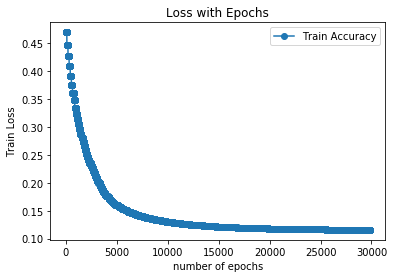

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Loss with Epochs")
x = np.arange(0,len(costs))
ax.plot(x, costs, marker='o', label='Train Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

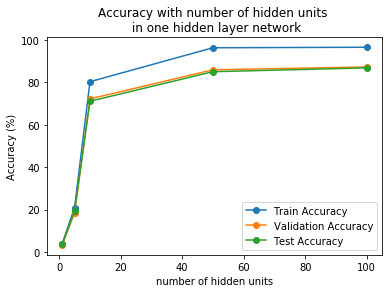

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("number of hidden units")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

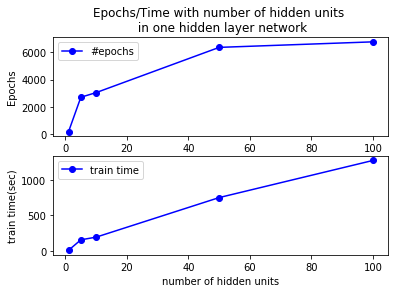

In [55]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
ax.set_xlabel("number of hidden units")
ax.set_ylabel("Epochs")
ax.legend()

ax1 = fig.add_subplot(212)
ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
ax1.set_xlabel("number of hidden units")
ax1.set_ylabel("train time(sec)")
plt.legend()
#plt.savefig("epochs_time_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of epochs for \n 1 hidden layer of 100 units")
ax.plot(plt_epoch, plt_train_acc, c='b', label='Train Accuracy')
ax.plot(plt_epoch, plt_val_acc, c='m',label='Validation Accuracy')
ax.plot(plt_epoch, plt_test_acc, c='g', label='Test Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_epoch_100_valloss.png", dpi=1000, bbox_inches='tight')
plt.show()